code: [1225,65]
code: [2025,81]
code: [625,25]
code: [625,25], valid neighbor counts per step (excluding initial): [ 7 16 20 19 14 16 17 14 20 17]
Total runtime for [625,25]: 3.0h 22.0m 27.831969022750854s


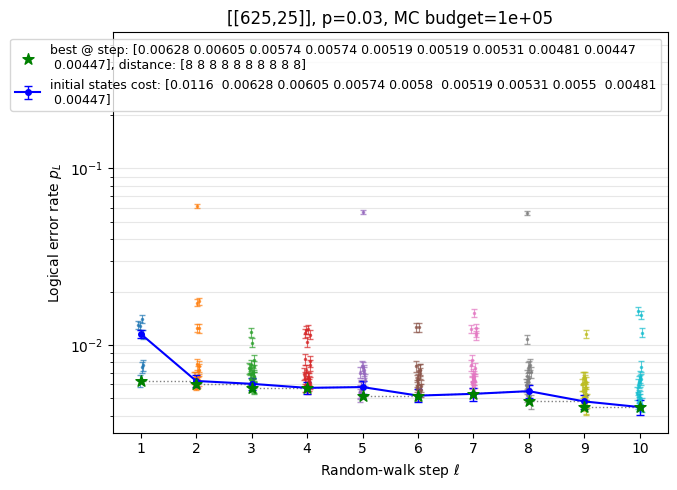

----------------------------------------------------------------------------------------------------
code: [1225,65], valid neighbor counts per step (excluding initial): [11 39 36 43 36 36 29 41 42 45]
Total runtime for [1225,65]: 20.0h 24.0m 33.55892300605774s


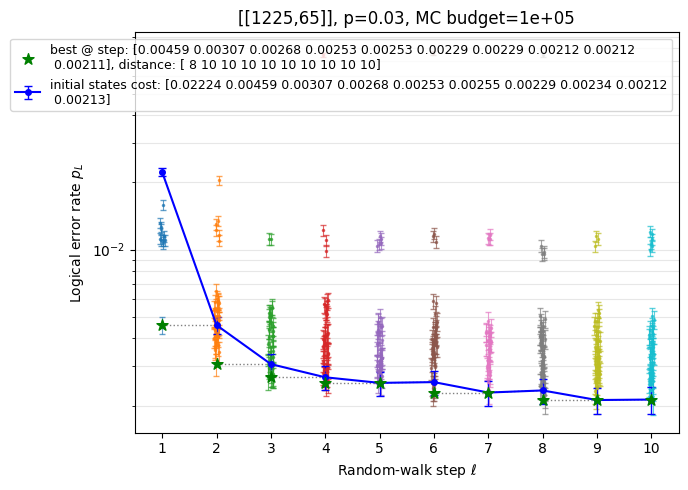

----------------------------------------------------------------------------------------------------
code: [2025,81], valid neighbor counts per step (excluding initial): [49 47 45 43 46 43 47 48 47 45]
Total runtime for [2025,81]: 53.0h 14.0m 29.06334900856018s


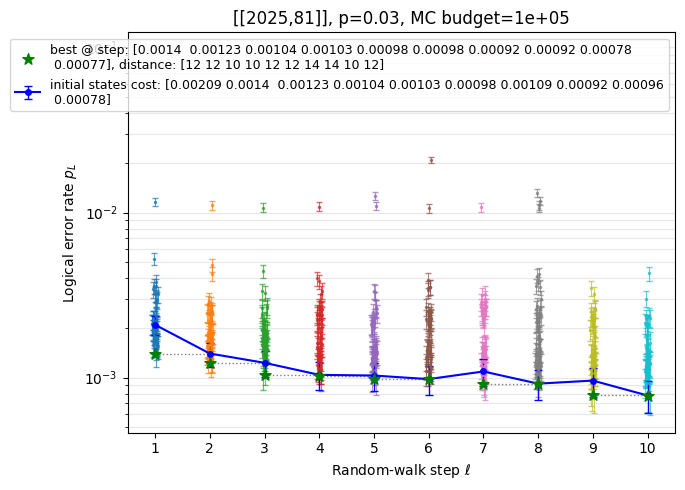

----------------------------------------------------------------------------------------------------


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

best_neighbor_search_path = '../results/best_neighbor_search.hdf5'

codes = ['[625,25]', '[1225,65]', '[2025,81]']
fn_data = {}

with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        fn_data[code] = {}
        fn_data[code]['N'] = grp.attrs['N']
        fn_data[code]['L'] = grp.attrs['L']
        fn_data[code]['osd_order'] = grp.attrs['osd_order']
        fn_data[code]['ms_scaling_factor'] = grp.attrs['ms_scaling_factor']
        fn_data[code]['MC_budget'] = grp.attrs['MC_budget']
        fn_data[code]['p'] = grp.attrs['p']
        fn_data[code]['total_runtime'] = grp.attrs['total_runtime']
        fn_data[code]['states'] = grp['states'][()].copy()
        fn_data[code]['logical_error_rates'] = grp['logical_error_rates'][()].copy()
        fn_data[code]['stds'] = grp['logical_error_rates_std'][()].copy()
        fn_data[code]['distances_quantum'] = grp['distances_quantum'][()].copy()
        fn_data[code]['distances_Hx'] = grp['distances_Hx'][()].copy()
        fn_data[code]['distances_Hz'] = grp['distances_Hz'][()].copy()
        fn_data[code]['distances_classical'] = grp['distances_classical'][()].copy()
        fn_data[code]['decoding_runtimes'] = grp['decoding_runtimes'][()].copy()

physical_error_rates = [fn_data[code]['p'] for code in codes]

exploration_params = {code: par for code, par in zip(codes, [(fn_data[code]['L'], fn_data[code]['N'])])}

exploration_params = {}

for code in fn_data:
    exploration_params[code] = (fn_data[code]['L'], fn_data[code]['N'])
    fn_data[code]['logical_error_rates'] = fn_data[code]['logical_error_rates'].reshape(exploration_params[code])
    fn_data[code]['stds'] = fn_data[code]['stds'].reshape(exploration_params[code])
    fn_data[code]['distances_quantum'] = fn_data[code]['distances_quantum'].reshape(exploration_params[code])

import matplotlib.pyplot as plt
import numpy as np

for code in codes:

    data = fn_data[code]

    L, N = data['logical_error_rates'].shape  # (steps, neighbors incl. initial)
    x_steps = np.arange(1, L+1)
    y = data['logical_error_rates']           # shape (L, N)
    yerr = 1.96 * data['stds']                # shape (L, N)
    distances_quantum = data['distances_quantum']
    distances_classical = data['distances_classical']

    fig, ax = plt.subplots(figsize=(7, 5))

    # Neighbor cloud per step (columns 1..N-1) with slight horizontal jitter
    # count how many valid (non-NaN, non-inf) neighbors we have per step
    valid_counts = np.sum((y[:, 1:] > 0), axis=1)
    print(f"code: {code}, valid neighbor counts per step (excluding initial): {valid_counts}")
    print(f"Total runtime for {code}: {data['total_runtime'] // 3600}h {data['total_runtime'] % 3600 // 60}m {data['total_runtime'] % 60}s")
    rng = np.random.default_rng(0)
    for ell in range(L):
        x_base = x_steps[ell]
        # draw neighbors at this step with small jitter
        nn = y[ell, 1:]
        nne = yerr[ell, 1:]
        jitter = (rng.uniform(-0.05, 0.05, size=nn.shape))
        xj = x_base + jitter
        # plot neighbor points
        ax.errorbar(
            xj, nn, yerr=nne,
            fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
        )
    # Initial state trace (column 0)
    ax.errorbar(
        x_steps, y[:, 0], yerr=yerr[:, 0],
        fmt='o-', color='b', markersize=4, elinewidth=1, capsize=3, label=f'initial states cost: {y[:, 0]}'
    )

    # Per-step best (min across all N at that step)
    # exclude zeros by turning them into +inf for the min search
    y_pos = np.where(y > 0, y, np.inf)            # shape (L, N)

    step_best_idx  = np.argmin(y_pos, axis=1)     # argmin among only positives

    step_best_cost = y_pos[np.arange(L), step_best_idx]

    step_best_distance = distances_quantum[np.arange(L), step_best_idx]

    # plot only valid rows
    ax.scatter(x_steps, step_best_cost, marker='*', color='g', s=70, label=f'best @ step: {step_best_cost}, distance: {step_best_distance}', zorder=3)

    # Optional dashed connector from best@step l to initial@(l+1)
    for ell in range(L-1):
        ax.plot(
            [x_steps[ell], x_steps[ell+1]],
            [step_best_cost[ell], y[ell+1, 0]],
            linestyle=':', linewidth=1, color='gray', alpha=1
        )

    # Formatting
    ax.set_title(f'[{code}], p={data["p"]}, MC budget={data["MC_budget"]:.0e}')
    ax.set_xlabel('Random-walk step $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)

    # ticks: show integer steps (thin out if L is large)
    if L <= 15:
        ax.set_xticks(x_steps)
    else:
        ax.set_xticks(np.linspace(1, L, 10, dtype=int))

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print("-"*100)

In [94]:
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix

from optimization.experiments_settings import from_edgelist, tanner_graph_to_parity_check_matrix
import ldpc
import ldpc.code_util

if '__file__' in globals():
    repo_root = Path(__file__).resolve().parents[1]   # one up from optimization/analyze_codes
else:
    # notebook: assume you're running from optimization/analyze_codes/
    repo_root = Path.cwd().parents[1]

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

out_dir = (repo_root / "optimization" / "results")
out_dir.mkdir(parents=True, exist_ok=True)

for code in codes:
    data = fn_data[code]
    N = int(data['N'])
    L = int(data['L'])

    classical_distances_H = data['distances_classical'].reshape(1, L*N)
    quantum_distances_Hx  = data['distances_Hx'].reshape(1, L*N)
    quantum_distances_Hz  = data['distances_Hz'].reshape(1, L*N)
    quantum_distances     = data['distances_quantum'].reshape(1, L*N)
    logical_error_rates   = data['logical_error_rates'].reshape(1, L*N)
    states                = data['states']  # shape: (L*N, E) typically

    max_row_w_H_list   = []
    max_row_w_HT_list  = []  # == max column weight of H
    k_classical_list   = []
    k_T_classical_list = []
    k_quantum_list     = []

    for state in states:
        G = from_edgelist(state)
        H = tanner_graph_to_parity_check_matrix(G)

        csr_H = csr_matrix(H, dtype=np.uint8)     # m x n
        # weights
        row_w = np.diff(csr_H.indptr)                         # per row of H
        col_w = np.diff(csc_matrix(csr_H, copy=False).indptr) # per col of H

        max_row_w_H_list.append(int(row_w.max()) if row_w.size else 0)
        max_row_w_HT_list.append(int(col_w.max()) if col_w.size else 0)

        r_c = ldpc.mod2.rank(csr_H)
        # classical [n, k, d] for H and H^T
        n_c, k_c, d_c = ldpc.code_util.compute_code_parameters(csr_H)

        if k_c == n_c - csr_H.shape[0]:
            n_ct = csr_H.shape[0]
            k_ct = n_ct - r_c
            d_ct = np.inf
        else:
            n_ct, k_ct, d_ct = ldpc.code_util.compute_code_parameters(csr_matrix(H.T, dtype=np.uint8))

        k_classical_list.append(int(k_c))
        k_T_classical_list.append(int(k_ct))

        # Hypergraph-product k for H with itself: k = k(H)^2 + k(H^T)^2
        k_q = int(k_c)*int(k_c) + int(k_ct)*int(k_ct)
        k_quantum_list.append(k_q)
    
    fn_data[code]['k_classical'] = np.array(k_classical_list, dtype=np.int32)
    fn_data[code]['k_classical_T'] = np.array(k_T_classical_list, dtype=np.int32)
    fn_data[code]['k_quantum'] = np.array(k_quantum_list, dtype=np.int32)

    # sanity check
    expected_len = L * N
    if len(max_row_w_H_list) != expected_len:
        print(f"Warning: states length {len(max_row_w_H_list)} != L*N {expected_len}")

    # build dataframe
    df = pd.DataFrame({
        'distances_classical': classical_distances_H.ravel(),
        'distances_Hx':  quantum_distances_Hx.ravel(),
        'distances_Hz':  quantum_distances_Hz.ravel(),
        'distances_quantum':     quantum_distances.ravel(),
        'logical_error_rates':   logical_error_rates.ravel(),
        'max_row_weight_H':      max_row_w_H_list,
        'max_row_weight_HT':     max_row_w_HT_list,
        'k_classical':           k_classical_list,
        'k_classical_T':         k_T_classical_list,
        'k_quantum':             k_quantum_list,
    })

    # save to file (CSV + Parquet)
    safe_code = code.strip('[]').replace(',', '-').replace(' ', '')
    csv_path = out_dir / f"features_{safe_code}_L{L}_N{N}.csv"
    parquet_path = out_dir / f"features_{safe_code}_L{L}_N{N}.parquet"

    # df.to_csv(csv_path, index=False)
    # try:
    #     df.to_parquet(parquet_path, index=False)
    # except Exception:
    #     # parquet optional; skip if pyarrow/fastparquet isn't installed
    #     pass

    print(f"Saved: {csv_path}")


Saved: /Users/dayeon/data/git/optimizing-qLDPC-code/optimization/results/features_625-25_L10_N50.csv
Saved: /Users/dayeon/data/git/optimizing-qLDPC-code/optimization/results/features_1225-65_L10_N50.csv
Saved: /Users/dayeon/data/git/optimizing-qLDPC-code/optimization/results/features_2025-81_L10_N50.csv


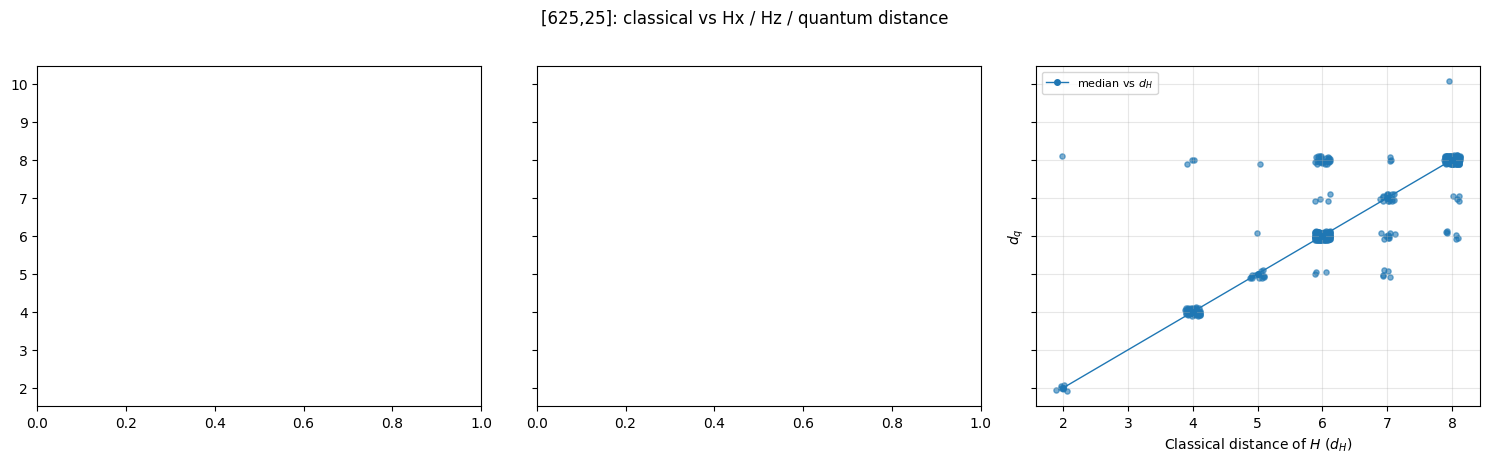

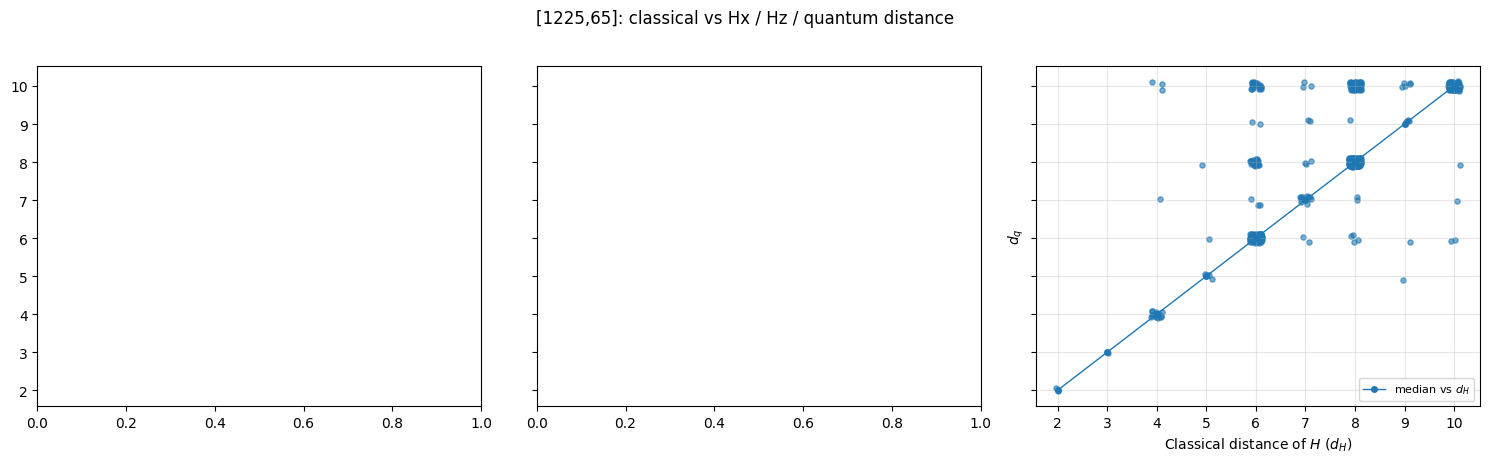

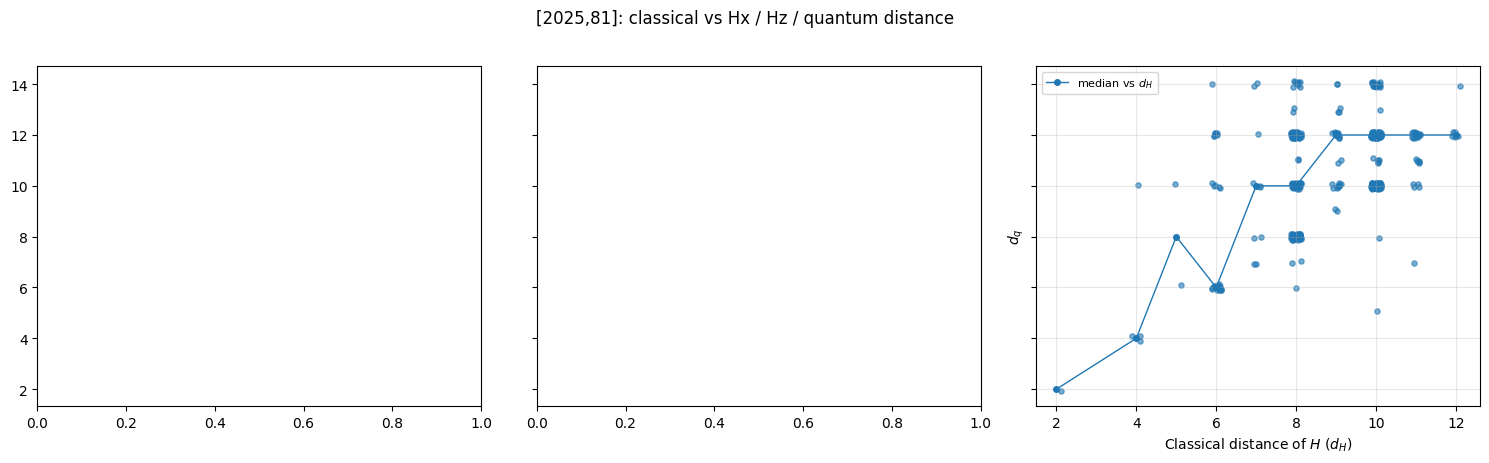

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

save_dir = out_dir  # you already defined out_dir earlier
save_dir.mkdir(parents=True, exist_ok=True)

def _flat(a):
    return a if a.ndim == 1 else a.reshape(-1)

for code in codes:
    d = fn_data[code]

    dH   = _flat(d['distances_classical']).astype(float)
    dHx  = _flat(d['distances_Hx']).astype(float)
    dHz  = _flat(d['distances_Hz']).astype(float)
    dq   = _flat(d['distances_quantum']).astype(float)
    pL   = _flat(d['logical_error_rates']).astype(float)

    # keep only positive/finite entries
    mask = (dH > 0) & (dHx > 0) & (dHz > 0) & (dq > 0) & np.isfinite(dH) & np.isfinite(dHx) & np.isfinite(dHz) & np.isfinite(dq)
    dH, dHx, dHz, dq = dH[mask], dHx[mask], dHz[mask], dq[mask]
    pL = pL[mask] if pL is not None else None

    rng = np.random.default_rng(0)
    jx = lambda n: rng.uniform(-0.12, 0.12, size=n)  # small jitter

    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True)
    pairs = [
        # (dHx, r'$d_{Hx}$', axes[0]),
        # (dHz, r'$d_{Hz}$', axes[1]),
        (dq,  r'$d_q$',    axes[2]),
    ]

    for yvals, ylabel, ax in pairs:
        # scatter
        if pL is not None and np.all(pL > 0):
            sc = ax.scatter(dH + jx(dH.size), yvals + jx(yvals.size), s=14, alpha=0.6, c=np.log10(pL))
        else:
            sc = ax.scatter(dH + jx(dH.size), yvals + jx(yvals.size), s=14, alpha=0.6)

        # median curve: median(y | dH)
        uniq = np.unique(dH)
        med  = np.array([np.median(yvals[dH == u]) for u in uniq])
        ax.plot(uniq, med, '-o', linewidth=1, markersize=4, label='median vs $d_H$')

        ax.set_xlabel(r'Classical distance of $H$ ($d_H$)')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=8)

    if pL is not None and np.all(pL > 0):
        cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.9)
        cbar.set_label(r'$\log_{10}(p_L)$')

    fig.suptitle(f'{code}: classical vs Hx / Hz / quantum distance', y=1.02)
    fig.tight_layout()

    # save
    # safe_code = code.strip('[]').replace(',', '-').replace(' ', '')
    # out_png = save_dir / f"classical_vs_Hx_Hz_quantum_{safe_code}.png"
    # fig.savefig(out_png, dpi=200, bbox_inches='tight')
    # plt.show()
    # print(f"Saved: {out_png}")
# classical_vs_Hx_Hz_quantum_distance_

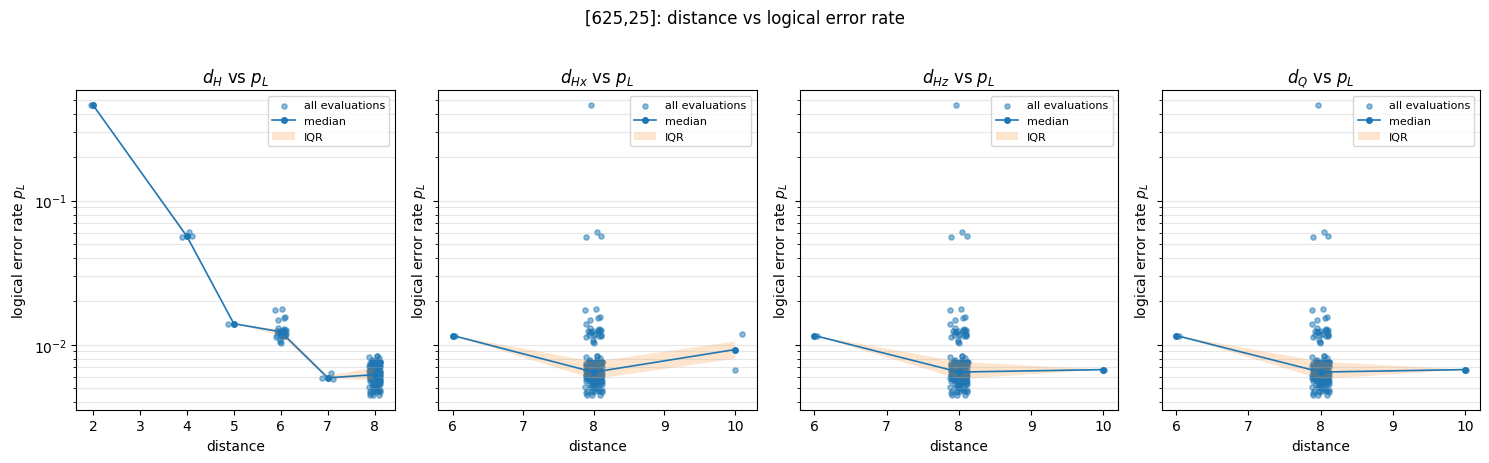

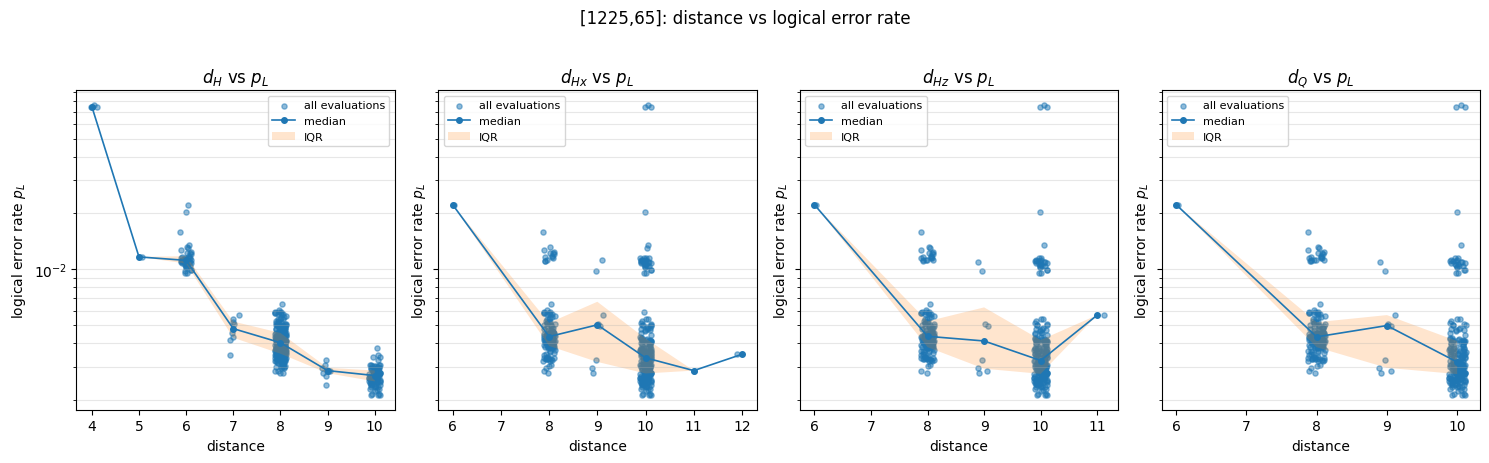

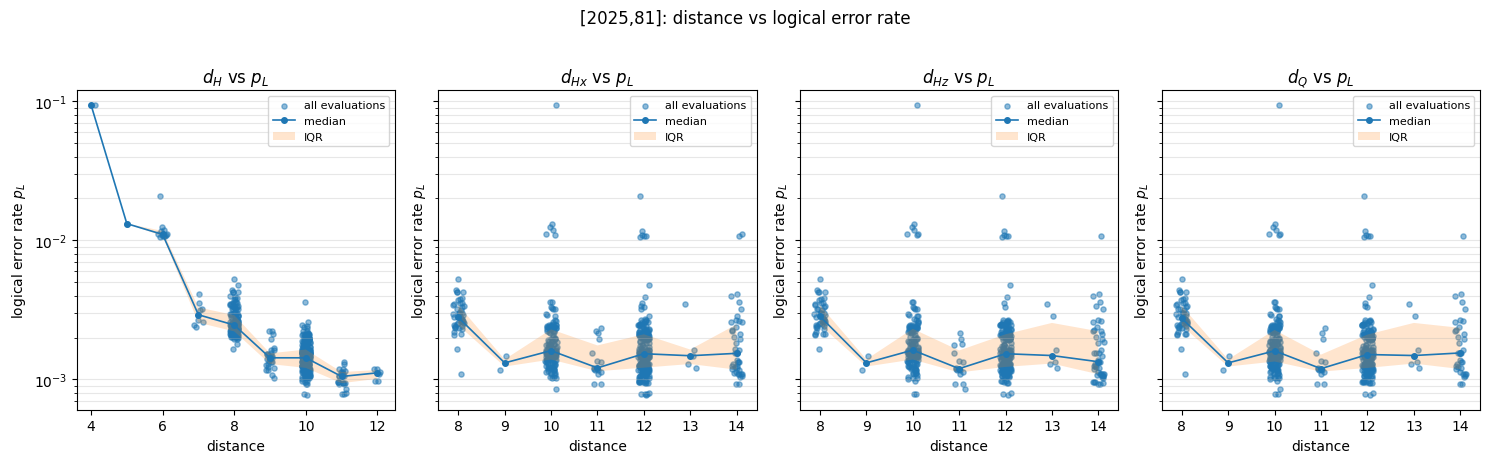

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# from scipy.stats import spearmanr  # optional stats

save_dir = out_dir  # you already defined out_dir earlier
save_dir.mkdir(parents=True, exist_ok=True)

def _flat(a):
    return a if a.ndim == 1 else a.reshape(-1)

def plot_dist_vs_pl(ax, xvals, pl, title):
    rng = np.random.default_rng(0)
    # scatter with small jitter (distances are integers)
    xj = xvals + rng.uniform(-0.12, 0.12, size=xvals.size)
    ax.scatter(xj, pl, s=14, alpha=0.5, rasterized=True, label='all evaluations')

    # aggregate: median ± IQR per distance value
    uniq = np.unique(xvals)
    med  = np.array([np.median(pl[xvals == u]) for u in uniq])
    q25  = np.array([np.percentile(pl[xvals == u], 25) for u in uniq])
    q75  = np.array([np.percentile(pl[xvals == u], 75) for u in uniq])

    ax.plot(uniq, med, '-o', markersize=4, linewidth=1.2, label='median')
    ax.fill_between(uniq, q25, q75, alpha=0.2, label='IQR')

    ax.set_title(title)
    ax.set_xlabel('distance')
    ax.set_ylabel('logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)
    ax.legend(fontsize=8)

for code in codes:
    d = fn_data[code]

    dH   = _flat(d['distances_classical']).astype(float)
    dHx  = _flat(d['distances_Hx']).astype(float)
    dHz  = _flat(d['distances_Hz']).astype(float)
    dQ   = _flat(d['distances_quantum']).astype(float)
    pL   = _flat(d['logical_error_rates']).astype(float)

    # keep valid entries (exclude zeros/placeholders and nonpositive pL)
    mask = (dH > 0) & (dHx > 0) & (dHz > 0) & (dQ > 0) & (pL > 0) & np.isfinite(dH) & np.isfinite(dHx) & np.isfinite(dHz) & np.isfinite(dQ) & np.isfinite(pL)
    dH, dHx, dHz, dQ, pL = dH[mask], dHx[mask], dHz[mask], dQ[mask], pL[mask]

    fig, axes = plt.subplots(1, 4, figsize=(15, 4.5), sharey=True)
    plot_dist_vs_pl(axes[0], dH,  pL, r'$d_H$ vs $p_L$')
    plot_dist_vs_pl(axes[1], dHx, pL, r'$d_{Hx}$ vs $p_L$')
    plot_dist_vs_pl(axes[2], dHz, pL, r'$d_{Hz}$ vs $p_L$')
    plot_dist_vs_pl(axes[3], dQ,  pL, r'$d_Q$ vs $p_L$')

    fig.suptitle(f'{code}: distance vs logical error rate', y=1.02)
    fig.tight_layout()

    safe_code = code.strip('[]').replace(',', '-').replace(' ', '')
    # out_png = save_dir / f"distance_vs_logical_error_{safe_code}.png"
    # fig.savefig(out_png, dpi=200, bbox_inches='tight')
    # plt.show()
    # print(f"Saved: {out_png}")

    # Optional: quantify monotonicity (rank correlation)
    # for name, x in [('d_H', dH), ('d_Hx', dHx), ('d_Hz', dHz)]:
    #     rho, pval = spearmanr(x, np.log(pL))
    #     print(f"{code}: Spearman rho({name}, log pL) = {rho:.3f} (p={pval:.1e})")


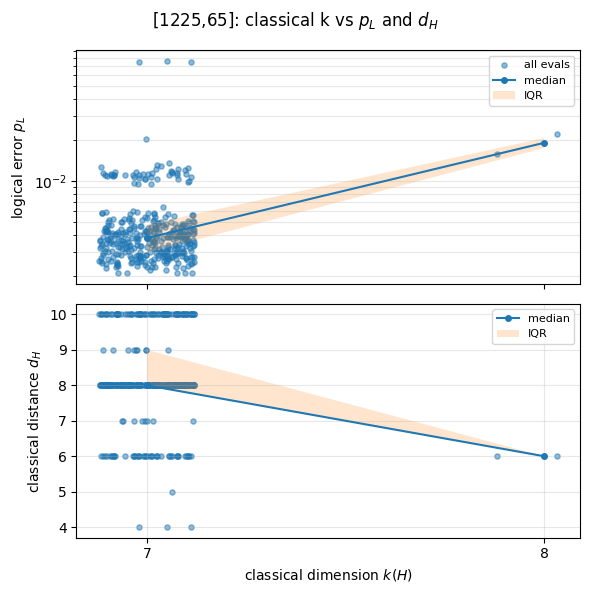

In [98]:
import numpy as np
import matplotlib.pyplot as plt

def _flat(a): return a if a.ndim == 1 else a.reshape(-1)

for code in ['[1225,65]']:
    d = fn_data[code]
    k  = _flat(d['k_classical']).astype(int)            # supply this array
    dH = _flat(d['distances_classical']).astype(float)
    pL = _flat(d['logical_error_rates']).astype(float)

    # keep valid points
    m = (k>=0) & (dH>0) & (pL>0) & np.isfinite(dH) & np.isfinite(pL)
    k, dH, pL = k[m], dH[m], pL[m]

    # jitter to avoid overplotting at integer k
    rng = np.random.default_rng(0)
    kj = k + rng.uniform(-0.12, 0.12, size=k.size)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

    # --- top: p_L vs k (log y) ---
    ax1.scatter(kj, pL, s=14, alpha=0.5, label='all evals', rasterized=True)
    # per-k median ± IQR
    uniq = np.unique(k)
    med  = np.array([np.median(pL[k==u]) for u in uniq])
    q25  = np.array([np.percentile(pL[k==u], 25) for u in uniq])
    q75  = np.array([np.percentile(pL[k==u], 75) for u in uniq])
    ax1.plot(uniq, med, '-o', markersize=4, label='median')
    ax1.fill_between(uniq, q25, q75, alpha=0.2, label='IQR')
    ax1.set_ylabel(r'logical error $p_L$')
    ax1.set_yscale('log'); ax1.grid(True, which='both', axis='y', alpha=0.3)
    ax1.legend(fontsize=8)

    # --- bottom: d_H vs k ---
    ax2.scatter(kj, dH, s=14, alpha=0.5, rasterized=True)
    med_dH = np.array([np.median(dH[k==u]) for u in uniq])
    q25_dH = np.array([np.percentile(dH[k==u], 25) for u in uniq])
    q75_dH = np.array([np.percentile(dH[k==u], 75) for u in uniq])
    ax2.plot(uniq, med_dH, '-o', markersize=4, label='median')
    ax2.fill_between(uniq, q25_dH, q75_dH, alpha=0.2, label='IQR')
    ax2.set_xlabel('classical dimension $k(H)$')
    ax2.set_ylabel(r'classical distance $d_H$')
    ax2.grid(True, alpha=0.3); ax2.legend(fontsize=8)
    ax2.set_xticks(uniq)

    fig.suptitle(f'{code}: classical k vs $p_L$ and $d_H$', y=0.98)
    fig.tight_layout()
    plt.show()


# Only [[1225, 65]] code with k threshold

code: [1225,65]
code: [1225,65], valid neighbor counts per step (excluding initial): [1 7 2 1 7 5 6 5 4 2]
Total runtime for [1225,65]: 2.0h 25.0m 53.179606914520264s


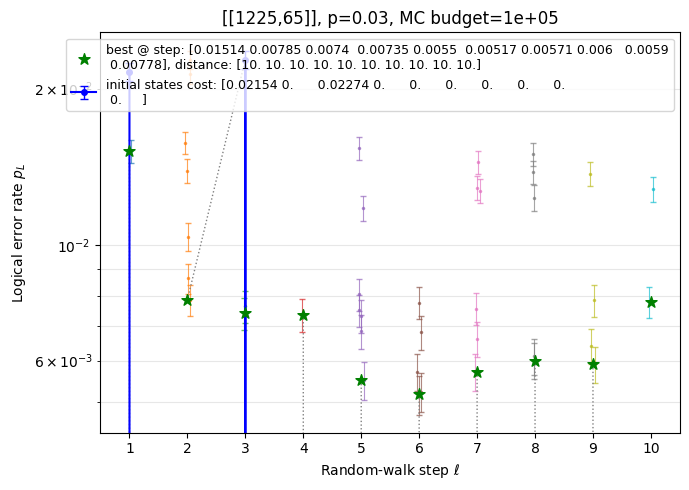

----------------------------------------------------------------------------------------------------


In [74]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

best_neighbor_search_path = '../results/best_neighbor_search_2.hdf5'

codes = ['[1225,65]']
fn_data = {}

with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        fn_data[code] = {}
        fn_data[code]['N'] = grp.attrs['N']
        fn_data[code]['L'] = grp.attrs['L']
        fn_data[code]['osd_order'] = grp.attrs['osd_order']
        fn_data[code]['ms_scaling_factor'] = grp.attrs['ms_scaling_factor']
        fn_data[code]['MC_budget'] = grp.attrs['MC_budget']
        fn_data[code]['p'] = grp.attrs['p']
        fn_data[code]['total_runtime'] = grp.attrs['total_runtime']
        fn_data[code]['states'] = grp['states'][()].copy()
        fn_data[code]['logical_error_rates'] = grp['logical_error_rates'][()].copy()
        fn_data[code]['stds'] = grp['logical_error_rates_std'][()].copy()
        fn_data[code]['distances_quantum'] = grp['distances_quantum'][()].copy()
        fn_data[code]['distances_Hx'] = grp['distances_Hx'][()].copy()
        fn_data[code]['distances_Hz'] = grp['distances_Hz'][()].copy()
        fn_data[code]['distances_classical'] = grp['distances_classical'][()].copy()
        fn_data[code]['decoding_runtimes'] = grp['decoding_runtimes'][()].copy()

physical_error_rates = [fn_data[code]['p'] for code in codes]

exploration_params = {code: par for code, par in zip(codes, [(fn_data[code]['L'], fn_data[code]['N'])])}

exploration_params = {}

for code in fn_data:
    exploration_params[code] = (fn_data[code]['L'], fn_data[code]['N'])
    fn_data[code]['logical_error_rates'] = fn_data[code]['logical_error_rates'][:-1].reshape(exploration_params[code])
    fn_data[code]['stds'] = fn_data[code]['stds'][:-1].reshape(exploration_params[code])
    fn_data[code]['distances_quantum'] = fn_data[code]['distances_quantum'][:-1].reshape(exploration_params[code])

import matplotlib.pyplot as plt
import numpy as np

for code in codes:

    data = fn_data[code]

    L, N = data['logical_error_rates'].shape  # (steps, neighbors incl. initial)
    x_steps = np.arange(1, L+1)
    y = data['logical_error_rates']           # shape (L, N)
    yerr = 1.96 * data['stds']                # shape (L, N)
    distances_quantum = data['distances_quantum']
    distances_classical = data['distances_classical']

    fig, ax = plt.subplots(figsize=(7, 5))

    # Neighbor cloud per step (columns 1..N-1) with slight horizontal jitter
    # count how many valid (non-NaN, non-inf) neighbors we have per step
    valid_counts = np.sum((y[:, 1:] > 0), axis=1)
    print(f"code: {code}, valid neighbor counts per step (excluding initial): {valid_counts}")
    print(f"Total runtime for {code}: {data['total_runtime'] // 3600}h {data['total_runtime'] % 3600 // 60}m {data['total_runtime'] % 60}s")
    rng = np.random.default_rng(0)
    for ell in range(L):
        x_base = x_steps[ell]
        # draw neighbors at this step with small jitter
        nn = y[ell, 1:]
        nne = yerr[ell, 1:]
        jitter = (rng.uniform(-0.05, 0.05, size=nn.shape))
        xj = x_base + jitter
        # plot neighbor points
        ax.errorbar(
            xj, nn, yerr=nne,
            fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
        )
    # Initial state trace (column 0)
    ax.errorbar(
        x_steps, y[:, 0], yerr=yerr[:, 0],
        fmt='o-', color='b', markersize=4, elinewidth=1, capsize=3, label=f'initial states cost: {y[:, 0]}'
    )

    # Per-step best (min across all N at that step)
    # exclude zeros by turning them into +inf for the min search
    y_pos = np.where(y > 0, y, np.inf)            # shape (L, N)

    step_best_idx  = np.argmin(y_pos, axis=1)     # argmin among only positives

    step_best_cost = y_pos[np.arange(L), step_best_idx]

    step_best_distance = distances_quantum[np.arange(L), step_best_idx]

    # plot only valid rows
    ax.scatter(x_steps, step_best_cost, marker='*', color='g', s=70, label=f'best @ step: {step_best_cost}, distance: {step_best_distance}', zorder=3)

    # Optional dashed connector from best@step l to initial@(l+1)
    for ell in range(L-1):
        ax.plot(
            [x_steps[ell], x_steps[ell+1]],
            [step_best_cost[ell], y[ell+1, 0]],
            linestyle=':', linewidth=1, color='gray', alpha=1
        )

    # Formatting
    ax.set_title(f'[{code}], p={data["p"]}, MC budget={data["MC_budget"]:.0e}')
    ax.set_xlabel('Random-walk step $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_yscale('log')
    ax.grid(True, which='both', axis='y', alpha=0.3)

    # ticks: show integer steps (thin out if L is large)
    if L <= 15:
        ax.set_xticks(x_steps)
    else:
        ax.set_xticks(np.linspace(1, L, 10, dtype=int))

    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print("-"*100)

In [75]:
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix

from optimization.experiments_settings import from_edgelist, tanner_graph_to_parity_check_matrix
import ldpc
import ldpc.code_util

if '__file__' in globals():
    repo_root = Path(__file__).resolve().parents[1]   # one up from optimization/analyze_codes
else:
    # notebook: assume you're running from optimization/analyze_codes/
    repo_root = Path.cwd().parents[1]

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

out_dir = (repo_root / "optimization" / "results")
out_dir.mkdir(parents=True, exist_ok=True)

for code in codes:
    data = fn_data[code]
    N = int(data['N'])
    L = int(data['L'])

    classical_distances_H = data['distances_classical'][:-1].reshape(1, L*N)
    quantum_distances_Hx  = data['distances_Hx'][:-1].reshape(1, L*N)
    quantum_distances_Hz  = data['distances_Hz'][:-1].reshape(1, L*N)
    quantum_distances     = data['distances_quantum'].reshape(1, L*N)
    logical_error_rates   = data['logical_error_rates'].reshape(1, L*N)
    states                = data['states'][:-1]  # shape: (L*N, E) typically

    max_row_w_H_list   = []
    max_row_w_HT_list  = []  # == max column weight of H
    k_classical_list   = []
    k_T_classical_list = []
    k_quantum_list     = []

    for state in states:
        G = from_edgelist(state)
        H = tanner_graph_to_parity_check_matrix(G)

        csr_H = csr_matrix(H, dtype=np.uint8)     # m x n
        # weights
        row_w = np.diff(csr_H.indptr)                         # per row of H
        col_w = np.diff(csc_matrix(csr_H, copy=False).indptr) # per col of H

        max_row_w_H_list.append(int(row_w.max()) if row_w.size else 0)
        max_row_w_HT_list.append(int(col_w.max()) if col_w.size else 0)

        r_c = ldpc.mod2.rank(csr_H)
        # classical [n, k, d] for H and H^T
        n_c, k_c, d_c = ldpc.code_util.compute_code_parameters(csr_H)

        if k_c == n_c - csr_H.shape[0]:
            n_ct = csr_H.shape[0]
            k_ct = n_ct - r_c
            d_ct = np.inf
        else:
            n_ct, k_ct, d_ct = ldpc.code_util.compute_code_parameters(csr_matrix(H.T, dtype=np.uint8))

        k_classical_list.append(int(k_c))
        k_T_classical_list.append(int(k_ct))

        # Hypergraph-product k for H with itself: k = k(H)^2 + k(H^T)^2
        k_q = int(k_c)*int(k_c) + int(k_ct)*int(k_ct)
        k_quantum_list.append(k_q)
    
    fn_data[code]['k_classical'] = np.array(k_classical_list, dtype=np.int32)
    fn_data[code]['k_classical_T'] = np.array(k_T_classical_list, dtype=np.int32)
    fn_data[code]['k_quantum'] = np.array(k_quantum_list, dtype=np.int32)

    # sanity check
    expected_len = L * N
    if len(max_row_w_H_list) != expected_len:
        print(f"Warning: states length {len(max_row_w_H_list)} != L*N {expected_len}")

    # build dataframe
    df = pd.DataFrame({
        'distances_classical': classical_distances_H.ravel(),
        'distances_Hx':  quantum_distances_Hx.ravel(),
        'distances_Hz':  quantum_distances_Hz.ravel(),
        'distances_quantum':     quantum_distances.ravel(),
        'logical_error_rates':   logical_error_rates.ravel(),
        'max_row_weight_H':      max_row_w_H_list,
        'max_row_weight_HT':     max_row_w_HT_list,
        'k_classical':           k_classical_list,
        'k_classical_T':         k_T_classical_list,
        'k_quantum':             k_quantum_list,
    })

    # save to file (CSV + Parquet)
    safe_code = code.strip('[]').replace(',', '-').replace(' ', '')
    csv_path = out_dir / f"features_{safe_code}_L{L}_N{N}_k_threshold.csv"
    parquet_path = out_dir / f"features_{safe_code}_L{L}_N{N}.parquet"

    df.to_csv(csv_path, index=False)
    try:
        df.to_parquet(parquet_path, index=False)
    except Exception:
        # parquet optional; skip if pyarrow/fastparquet isn't installed
        pass

    print(f"Saved: {csv_path}")


Saved: /Users/dayeon/data/git/optimizing-qLDPC-code/optimization/results/features_1225-65_L10_N50_k_threshold.csv


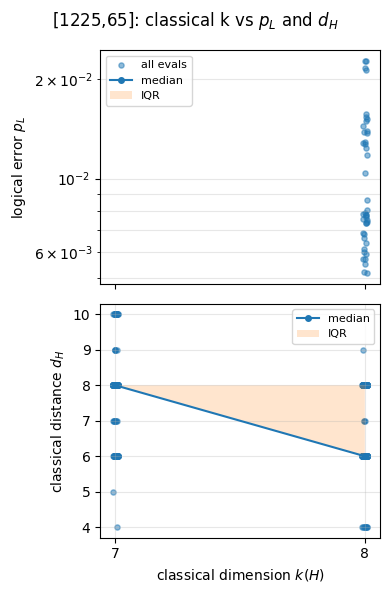

In [91]:
import numpy as np
import matplotlib.pyplot as plt

def _flat(a): return a if a.ndim == 1 else a.reshape(-1)

for code in ['[1225,65]']:
    d = fn_data[code]
    k  = _flat(d['k_classical']).astype(int)            # supply this array
    dH = _flat(d['distances_classical'])[:-1].astype(float)
    pL = _flat(d['logical_error_rates']).astype(float)

    # keep valid points
    m = (k>=0) & (dH>0) & np.isfinite(dH) & np.isfinite(pL)
    k, dH, pL = k[m], dH[m], pL[m]

    # jitter to avoid overplotting at integer k
    rng = np.random.default_rng(0)
    kj = k + rng.uniform(-0.01, 0.01, size=k.size)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

    # --- top: p_L vs k (log y) ---
    ax1.scatter(kj, pL, s=14, alpha=0.5, label='all evals', rasterized=True)
    # per-k median ± IQR
    uniq = np.unique(k)
    med  = np.array([np.median(pL[k==u]) for u in uniq])
    q25  = np.array([np.percentile(pL[k==u], 25) for u in uniq])
    q75  = np.array([np.percentile(pL[k==u], 75) for u in uniq])
    ax1.plot(uniq, med, '-o', markersize=4, label='median')
    ax1.fill_between(uniq, q25, q75, alpha=0.2, label='IQR')
    ax1.set_ylabel(r'logical error $p_L$')
    ax1.set_yscale('log'); ax1.grid(True, which='both', axis='y', alpha=0.3)
    ax1.legend(fontsize=8)

    # --- bottom: d_H vs k ---
    ax2.scatter(kj, dH, s=14, alpha=0.5, rasterized=True)
    med_dH = np.array([np.median(dH[k==u]) for u in uniq])
    q25_dH = np.array([np.percentile(dH[k==u], 25) for u in uniq])
    q75_dH = np.array([np.percentile(dH[k==u], 75) for u in uniq])
    ax2.plot(uniq, med_dH, '-o', markersize=4, label='median')
    ax2.fill_between(uniq, q25_dH, q75_dH, alpha=0.2, label='IQR')
    ax2.set_xlabel('classical dimension $k(H)$')
    ax2.set_ylabel(r'classical distance $d_H$')
    ax2.grid(True, alpha=0.3); ax2.legend(fontsize=8)
    ax2.set_xticks(uniq)

    fig.suptitle(f'{code}: classical k vs $p_L$ and $d_H$', y=0.98)
    fig.tight_layout()
    plt.show()
